In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import os

# Lemmatizer

In [2]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Stemming


In [3]:
from nltk.stem.porter import PorterStemmer
import re
token_pattern=r"(?u)\b\w\w+\b"
compiled_reg_exp = re.compile(token_pattern)
def StemTokenizer(text):
    tokens = compiled_reg_exp.findall(text)
    stems = []
    for item in tokens:
        if len(item)>100:
            item = 'tooLongWord'
        stems.append(PorterStemmer().stem(item))
    return stems

# Open dataset and split into Train set and Validate set
Hold-Out vs K-folding

In [4]:
!pwd

/content


In [5]:
# Dataset
# folder = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/'
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

# Split
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)
print(len(Y_train[0]))
# Raw datasets
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

6


# Vectorize

Para realizar la vectorización, se podría hacer a través de count vectorizer o tf-idf vectorizer. Por un lado, count vectorizer separa las palabras por la frecuencia de ocurrencia. Es una manera simple de ordenar las palabras para entender el contenido de un dataset con base en cuáles son las palabras comunes. Igualmente, count vectorizer tiene ciertas limitaciones. Por ejemplo, asume que las palabras más frecuentes son las más importantes, cuando necesariamente no es ese el caso. También, es incapaz de determinar la importancia de las palabras en sí, ya que se basa solo en la frecuencia de ocurrencia. Y finalmente, no reconoce las similitudes y relaciones que pueden tener las palabras.
Es por eso que se tiene el term frequency–inverse document frequency, o tf-idf, vectorizer. El objetivo de tfidf es no solamente ordenar las palabras por frecuencia de ocurrencia, sino también por su importancia. El proceso se puede dividir en dos partes, la parte tf, y la parte idf. La parte tf, o 'term frequency' funciona similar al count vectorizer, ya que ordena las palabras por su frecuencia de ocurrencia relatva, es decir, dentro de cada documento particular. Mientras tanto, el idf, o 'inverse document frecuency', nos determina la importancia de cada palabra basándose en que tanta información nos provee. En particular, se estima la cantidad de información de cada palabra en relación con la inversa de su frecuencia de ocurrencia, es decir, cuanto menos veces ocurra la palabra, se obtiene más información.
Es decir, la importancia se define como un balance entre que tantas veces ocurre una palabra con poca ocurrencia. Se puede decir entonces que tf-idf determina que una palabra dentro de un documento es importante si se utiliza muchas veces en un documento, pero pocas veces en todos los documentos. De esta manera, puede corregir las limitaciones del count vectorizer, ya que se puede estimar la importancia de cada palabra más allá de su frecuencia de ocurrencia.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 200000

tfidf_vectorizer = TfidfVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   #tokenizer=StemTokenize,
                                   #tokenizer=LemmaTokenize,
                                   stop_words='english')

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

CPU times: user 7.88 s, sys: 115 ms, total: 8 s
Wall time: 8.03 s


In [7]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

CPU times: user 812 ms, sys: 3.58 ms, total: 815 ms
Wall time: 819 ms


In [8]:
%time tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

CPU times: user 7.08 s, sys: 26.6 ms, total: 7.11 s
Wall time: 7.11 s


# Bag of Words
wtf is BoW

# Reducción de Dimensionalidad

In [9]:
from sklearn.decomposition import TruncatedSVD

trunSVD = TruncatedSVD(n_components=300)
%time dense_matrix_train = trunSVD.fit_transform(tfidf_matrix_train)

CPU times: user 1min 40s, sys: 9.08 s, total: 1min 49s
Wall time: 1min 13s


In [10]:
%time dense_matrix_valid = trunSVD.transform(tfidf_matrix_valid)

CPU times: user 278 ms, sys: 3.91 ms, total: 281 ms
Wall time: 284 ms


In [11]:
dense_matrix_train.shape, dense_matrix_valid.shape

((143613, 300), (15958, 300))

In [12]:
len(dense_matrix_train[0])

300

In [13]:
%time dense_matrix_test = trunSVD.transform(tfidf_matrix_test)

CPU times: user 1.32 s, sys: 3.54 ms, total: 1.32 s
Wall time: 1.33 s


# Train Model

In [14]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation

In [15]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]

model = Sequential()
model.add(Dense(20, activation = 'sigmoid', input_dim=input_features, name='Capa_Oculta_1'))
model.add(Dense(output_size, activation = 'sigmoid',name='Capa_Final'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta_1 (Dense)       (None, 20)                6020      
                                                                 
 Capa_Final (Dense)          (None, 6)                 126       
                                                                 
Total params: 6,146
Trainable params: 6,146
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy', optimizer = 'adam')

In [18]:
batch_size = 128
epochs = 10

model.fit(dense_matrix_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(dense_matrix_valid, Y_valid))

Epoch 1/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.1983 - val_loss: 0.1330
Epoch 2/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.1233 - val_loss: 0.1152
Epoch 3/10
1122/1122 [==============================] - 2s 2ms/step - loss: 0.1048 - val_loss: 0.0967
Epoch 4/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.0890 - val_loss: 0.0842
Epoch 5/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.0792 - val_loss: 0.0774
Epoch 6/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.0739 - val_loss: 0.0739
Epoch 7/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.0710 - val_loss: 0.0719
Epoch 8/10
1122/1122 [==============================] - 3s 2ms/step - loss: 0.0693 - val_loss: 0.0707
Epoch 9/10
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0683 - val_loss: 0.0700
Epoch 10/10
1122/1122 [==============================] - 2s 2ms/step - loss: 0.067

# Predict

In [19]:
pred_test = model.predict(dense_matrix_test)

In [20]:
submission[list_classes] = pred_test
submission.to_csv("submission_model.csv", index = False)

# Evaluate

In [21]:
pred_valid = model.predict(dense_matrix_valid, verbose = 1)
pred_train = model.predict(dense_matrix_train, verbose = 1)
pred_test = model.predict(dense_matrix_test, verbose = 1)

4787/4787 [==============================] - 6s 1ms/step


In [22]:
model.evaluate(dense_matrix_valid, Y_valid)

499/499 [==============================] - 1s 1ms/step - loss: 0.0694


0.06935860961675644

# Predict for Test

In [23]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)
%time dense_matrix_train = trunSVD.fit_transform(tfidf_matrix_train)

CPU times: user 1min 46s, sys: 12.2 s, total: 1min 58s
Wall time: 1min 22s


In [24]:
pred = model.predict(dense_matrix_test, verbose=1)

4787/4787 [==============================] - 7s 1ms/step


In [25]:
submission[list_classes] = pred
submission.to_csv("submission_test.csv", index = False)

# F1 score

In [29]:
from sklearn.metrics import f1_score

In [30]:
testing_labels = pd.read_csv("/content/test_labels.csv")
testing_clean = pd.merge(test, testing_labels)

In [31]:
avg = 0
for i,label in enumerate(list_classes):
    print(label, ":")
    pb = pred[:, i] >= 0.5
    score = f1_score(testing_clean[label], pb, average="weighted")
    print(score)
    avg += score

avg /= len(list_classes)
print("Average f1-score:", avg)

toxic :
0.23303576430573444
severe_toxic :
0.24478758509664086
obscene :
0.24047450607844337
threat :
0.24476180581799237
insult :
0.2385587544744099
identity_hate :
0.24166309534380737
Average f1-score: 0.24054691851950474


# ROC Curve


In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

0.9566543571851645
0.9529046372672672


In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


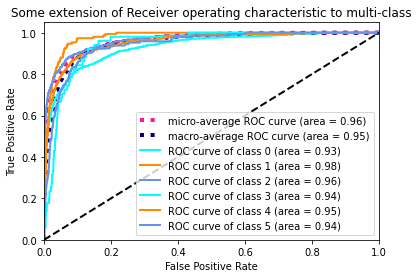

In [28]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()